In [1]:
import pandas as pd
from pymongo import MongoClient
from pprint import pprint

# Matrix decomposition imports
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity



In [2]:
# create a client that uses the default port on localhost
# I want to use the Mongo software in the datawarehouse
client = MongoClient("mongodb://localhost:27017/")

# Mongo 

In [3]:
# confirm connection with mongo
client.database_names()

/Users/ronald-daley/anaconda3/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: database_names is deprecated. Use list_database_names instead.
  


['admin', 'books', 'config', 'local', 'outings', 'recipe_db']

## create database

In [4]:
# Create a recipe database and assign to an object - in Mongo, a database isn't created until I enter information

recipe_db = client["recipe_db"]
recipe_db

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'recipe_db')

## create collection

In [5]:
# create a collection (table)
mycol = recipe_db["epicurious"]

## import json document and assign to variable

In [6]:
# import json document and create a document 

import json

with open('full_format_recipes.json') as f:
    file_data = json.load(f)

In [5]:
file_data

[{'directions': ['1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat to low and simmer until the lentils are tender, about 30 minutes, depending on the lentils. (If they begin to dry out, add water as needed.) Remove and discard the thyme. Drain and transfer the mixture to a bowl; let cool.',
   '2. Fold in the tomato, apple, lemon juice, and olive oil. Season with the pepper.',
   '3. To assemble a wrap, place 1 lavash sheet on a clean work surface. Spread some of the lentil mixture on the end nearest you, leaving a 1-inch border. Top with several slices of turkey, then some of the lettuce. Roll up the lavash, slice crosswise, and serve. If using tortillas, spread the lentils in the center, top with the turkey and lettuce, and fold up the bottom, left side, and right side before rolling away from you.'],
  'fat': 7.0,
  'date': '2006-09-01T04:00:00.000Z',
  'categories': ['Sandwich',
   'Bean',
   'Fruit',
   'Tomato',
  

## insert data into collection

In [8]:
#mycol.insert_many(file_data)  

## Mongo verifications

In [6]:
# view the list of database names in mongo
db_names = client.list_database_names()
db_names

['admin', 'books', 'config', 'local', 'outings', 'recipe_db']

In [7]:
# count the doucments (recipes) in my collection
mycol.count_documents({})

40260

In [8]:
mycol

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'recipe_db'), 'epicurious')

In [9]:
# Query Mongo to find the recipe with the title "The Best Blts"
myquery = { "title": "The Best Blts " }

In [10]:
mydoc = mycol.find(myquery)

for x in mydoc:
    print(x)

{'_id': ObjectId('5dc1e23d977083d5a031fa25'), 'directions': ['Mix basil, mayonnaise and butter in processor until basil is finely chopped and mixture is well blended. Season to taste with salt and pepper. (Can be made 1 day ahead. Cover and refrigerate.)', 'Cook bacon in heavy large skillet over medium-high heat until crisp, about 8 minutes. Transfer to paper towels; drain.', 'Spread half of mayonnaise mixture over 1 side of 6 bread slices. Top each with 2 tomato slices. Sprinkle tomatoes with salt and pepper. Top tomato slices with avocado, then with bacon strips, onion and lettuce. Spread remaining mayonnaise mixture over remaining 6 bread slices. Place bread slices atop lettuce. Cut sandwiches in half and serve.'], 'fat': 79.0, 'date': '2004-08-20T04:00:00.000Z', 'categories': ['Sandwich', 'Food Processor', 'Tomato', 'Kid-Friendly', 'Quick & Easy', 'Basil', 'Bacon', 'Summer', 'Lettuce', 'Bon Appétit'], 'calories': 948.0, 'desc': 'This recipe can be prepared in 45 minutes or less.', 

In [11]:
# query to find all documents and assign to an object
docs = mycol.find({})

In [12]:
# convert the docs to a list
list_docs = list(docs)

In [13]:
# convert the list to a string
st_docs = str(list_docs)

In [14]:
# convert list to a dataframe
df_docs_OG = pd.DataFrame(list_docs)

In [15]:
df_docs_OG.columns

Index(['_id', 'directions', 'fat', 'date', 'categories', 'calories', 'desc',
       'protein', 'rating', 'title', 'ingredients', 'sodium'],
      dtype='object')

In [19]:
# remove duplicate recipes 
df_docs_OG = df_docs_OG.drop_duplicates('title')

In [20]:
df_docs_OG.columns

Index(['_id', 'directions', 'fat', 'date', 'categories', 'calories', 'desc',
       'protein', 'rating', 'title', 'ingredients', 'sodium'],
      dtype='object')

# Create dataframe for DTM

In [21]:
# keep the ingredients and title columns

df_dtm = df_docs_OG.drop(columns=['_id', 'directions', 'fat', 'date', 'categories', 'calories', 'desc',
       'protein', 'rating', 'sodium'])

In [22]:
df_dtm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17776 entries, 0 to 20129
Data columns (total 2 columns):
title          17775 non-null object
ingredients    17775 non-null object
dtypes: object(2)
memory usage: 416.6+ KB


In [23]:
df_dtm = df_dtm.reset_index(drop=True)

In [24]:
df_dtm = df_dtm.dropna()

In [25]:
df_dtm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17775 entries, 0 to 17775
Data columns (total 2 columns):
title          17775 non-null object
ingredients    17775 non-null object
dtypes: object(2)
memory usage: 416.6+ KB


# Latent Semantic Analysis (LSA) with CV
 
SVD for Text Data.

Acronynms: Latent Semantic Analysis (LSA) is just another name forSignular Value Decomposition (SVD) applied to Natural Language Processing (NLP)

## Count Vecotorizer for LSA

In [34]:
# convert the recipe column to a string for the DTM
series_ing = df_dtm['title'].astype(str)
type(series_ing)

pandas.core.series.Series

In [35]:
vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english', max_df=.9, min_df=.001, token_pattern="\\b[a-z][a-z]+\\b")
doc_word = vectorizer.fit_transform(series_ing)
doc_word.shape

(17775, 896)

### DTM Dataframe

In [36]:
pd.DataFrame(doc_word.toarray(), index=series_ing, columns=vectorizer.get_feature_names()).head(1)

,almond,almond cake,almonds,ancho,anchovy,angel,anise,apple,apple cider,apple pie,...,wine sauce,wings,winter,wrapped,wraps,yams,yellow,yogurt,yogurt sauce,zucchini
title,,,,,,,,,,,,,,,,,,,,,
"Lentil, Apple, and Turkey Wrap",0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## LSA Model

In [37]:
# create LSA model 
lsa = TruncatedSVD(3)

# fit and transform model on the DTM 
doc_topic = lsa.fit_transform(doc_word) 

 # variance of topics i.e. topic 1: captures 1.5% of variance topic 
lsa.explained_variance_ratio_

array([0.01503646, 0.02111607, 0.01662318])

In [38]:
lsa.singular_values_

array([45.5621958 , 39.64712739, 35.3705444 ])

In [ ]:
# model typically captures low variance for text data so this is expected

## LSA - Resulting Principal Components

The matrix shows the resulting topics, and the terms that are associated with each topic.

In [39]:
# Matrix (3 components)
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2", "component_3"],
             columns = vectorizer.get_feature_names())

# view components components 
topic_word

,almond,almond cake,almonds,ancho,anchovy,angel,anise,apple,apple cider,apple pie,...,wine sauce,wings,winter,wrapped,wraps,yams,yellow,yogurt,yogurt sauce,zucchini
component_1,0.020,0.002,0.007,0.005,0.005,0.002,0.004,0.044,0.003,0.001,...,0.012,0.007,0.006,0.005,0.002,0.001,0.008,0.035,0.012,0.019
component_2,0.013,0.001,-0.001,0.006,0.002,0.002,0.003,-0.001,0.001,0.001,...,0.015,0.004,-0.000,0.001,0.000,0.000,-0.002,0.021,0.018,-0.002
component_3,0.031,0.006,0.002,-0.002,-0.001,0.002,0.004,0.033,0.004,0.003,...,-0.007,-0.007,-0.000,0.002,0.000,0.000,0.000,-0.007,-0.008,0.005


## Function to display topics 

In [32]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

## Topics

In [40]:
# display the top words in each topic
display_topics(lsa, vectorizer.get_feature_names(), 10)


Topic  0
salad, sauce, chicken, cheese, roasted, tomato, red, grilled, cream, lemon

Topic  1
sauce, cream, chocolate, pork, ice, ice cream, cake, tomato sauce, chicken, lemon

Topic  2
cheese, cream, goat, goat cheese, chocolate, cake, ice, ice cream, cream cheese, frosting


## LSA - Documents breakout per topic

The matrix shows the documents I started with, and how each document is made up of the resulting topics.

In [41]:
# Matrix

Vt = pd.DataFrame(doc_topic.round(5),
             index = series_ing,
             columns = ["Topic_0","Topic_1", "Topic_2" ])

# look at the breakout of first 10 documents in each topic
Vt.head(10)

,Topic_0,Topic_1,Topic_2
title,,,
"Lentil, Apple, and Turkey Wrap",0.08483,0.00138,0.03137
Boudin Blanc Terrine with Red Onion Confit,0.27316,-0.03583,-0.02969
Potato and Fennel Soup Hodge,0.21124,-0.10967,0.03605
Mahi-Mahi in Tomato Olive Sauce,0.65198,0.70445,-0.26331
Spinach Noodle Casserole,0.06519,-0.02574,-0.00293
The Best Blts,-0.00000,-0.00000,-0.00000
Ham and Spring Vegetable Salad with Shallot Vinaigrette,0.67030,-0.71895,-0.15805
Spicy-Sweet Kumquats,0.09424,0.02288,-0.01913
Korean Marinated Beef,0.05474,0.01864,-0.01955


## LSA-CV Takeaways: 
- % of variation captured in the 3 PCs is low for each PC. (1.5 - 2.1%)
- top words in each topic are random. need to try other methods (NMF)

# Non-Negative Matrix Factorization (NMF) with CV

## Count Vectorizer for NMF

In [43]:
vectorizer_nmf = CountVectorizer(stop_words = 'english', max_df = .9, min_df = .001, ngram_range=(1, 2))

doc_word_nmf = vectorizer_nmf.fit_transform(series_ing)

pd.DataFrame(doc_word_nmf.toarray(), index=series_ing, columns=vectorizer_nmf.get_feature_names()).head(1)

,almond,almond cake,almonds,ancho,anchovy,angel,anise,apple,apple cider,apple pie,...,wine sauce,wings,winter,wrapped,wraps,yams,yellow,yogurt,yogurt sauce,zucchini
title,,,,,,,,,,,,,,,,,,,,,
"Lentil, Apple, and Turkey Wrap",0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## NMF Model

In [44]:
# create NMF model 
nmf_model = NMF(3)

# fit NMF model to bag of words
doc_topic_nmf = nmf_model.fit_transform(doc_word_nmf)

## NMF - Resulting Principal Components

The matrix shows the resulting topics, and the terms that are associated with each topic

In [45]:
# probability distribution of all the words
topic_word_nmf = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2", "component_3"],
             columns = vectorizer_nmf.get_feature_names())
topic_word_nmf 

,almond,almond cake,almonds,ancho,anchovy,angel,anise,apple,apple cider,apple pie,...,wine sauce,wings,winter,wrapped,wraps,yams,yellow,yogurt,yogurt sauce,zucchini
component_1,0.023,0.000,0.037,0.000,0.018,0.000,0.005,0.214,0.006,0.000,...,0.000,0.009,0.038,0.010,0.005,0.003,0.055,0.088,0.000,0.093
component_2,0.054,0.000,0.014,0.047,0.024,0.012,0.015,0.092,0.008,0.000,...,0.119,0.049,0.022,0.021,0.006,0.005,0.016,0.221,0.135,0.047
component_3,0.211,0.036,0.026,0.005,0.001,0.014,0.030,0.235,0.024,0.018,...,0.000,0.000,0.010,0.022,0.007,0.006,0.013,0.041,0.000,0.062


## Topics

In [46]:
display_topics(nmf_model, vectorizer_nmf.get_feature_names(), 10)


Topic  0
salad, dressing, chicken, potato, red, grilled, green, roasted, bean, vinaigrette

Topic  1
sauce, chicken, tomato, pork, red, grilled, roasted, mustard, garlic, pepper

Topic  2
cheese, cream, goat, goat cheese, chocolate, cake, ice, ice cream, cream cheese, lemon


## NMF - Document breakout per topic

The matrix shows the documents I started with, and how each document is made up of the 2 resulting topics.

In [47]:
H = pd.DataFrame(doc_topic_nmf.round(5),
             index = series_ing,
             columns = ["component_1","component_2", "component_3"  ])
H.head(10)

,component_1,component_2,component_3
title,,,
"Lentil, Apple, and Turkey Wrap",0.00623,0.00619,0.00757
Boudin Blanc Terrine with Red Onion Confit,0.02605,0.02071,0.00227
Potato and Fennel Soup Hodge,0.02847,0.00000,0.01153
Mahi-Mahi in Tomato Olive Sauce,0.00000,0.18454,0.00000
Spinach Noodle Casserole,0.00798,0.00257,0.00212
The Best Blts,0.00000,0.00000,0.00000
Ham and Spring Vegetable Salad with Shallot Vinaigrette,0.14088,0.00000,0.00000
Spicy-Sweet Kumquats,0.00499,0.01294,0.00236
Korean Marinated Beef,0.00234,0.00922,0.00000


## NMF-CV Takeaways: 
- top words are starting to make more sense with the topics
- topic guesses: 
    - Topic 0: Healthier chicken based dishes
    - Topic 1: Pork dishes
    - Topic 2: Dessert

# Latent Semantic Analysis (LSA) with TF-IDF vecotorization 

## Tf-idf for LSA

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf1 = TfidfVectorizer(stop_words='english', min_df=.001)
doc_word_tfidf1 = tfidf1.fit_transform(series_ing)
doc_word_tfidf1.shape

(17775, 678)

## DTM Dataframe

In [49]:
pd.DataFrame(doc_word_tfidf1.toarray(), index=series_ing, columns=tfidf1.get_feature_names()).head(1)

,almond,almonds,ancho,anchovy,angel,anise,apple,apples,apricot,apricots,...,wilted,wine,wings,winter,wrapped,wraps,yams,yellow,yogurt,zucchini
title,,,,,,,,,,,,,,,,,,,,,
"Lentil, Apple, and Turkey Wrap",0.0,0.0,0.0,0.0,0.0,0.0,0.505463,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## LSA Model

In [50]:
# create LSA model 
lsa_tf = TruncatedSVD(3)

# fit and transform model on the DTM
doc_topic_tf = lsa_tf.fit_transform(doc_word_tfidf1) 

 # variance of topics i.e. topic 1: captures 1.7% of variance topic 
lsa_tf.explained_variance_ratio_

array([0.00696563, 0.01150293, 0.01093207])

## LSA - Resulting Principal Components

In [51]:
# PC-Matrix
topic_word_tf = pd.DataFrame(lsa_tf.components_.round(3),
             index = ["component_1","component_2", "component_3"],
             columns = tfidf1.get_feature_names())

# view components components 
topic_word_tf

,almond,almonds,ancho,anchovy,angel,anise,apple,apples,apricot,apricots,...,wilted,wine,wings,winter,wrapped,wraps,yams,yellow,yogurt,zucchini
component_1,0.030,0.010,0.007,0.007,0.003,0.005,0.054,0.011,0.016,0.005,...,0.007,0.039,0.012,0.009,0.006,0.003,0.003,0.011,0.046,0.031
component_2,-0.035,0.000,-0.008,-0.002,-0.004,-0.004,-0.003,-0.005,-0.017,-0.003,...,0.000,-0.027,-0.005,-0.000,-0.001,0.000,-0.001,0.005,-0.029,0.005
component_3,-0.035,0.002,-0.002,-0.002,-0.003,-0.004,-0.040,0.000,-0.009,-0.002,...,-0.000,-0.007,0.025,-0.005,-0.002,0.001,0.000,-0.002,-0.016,-0.012


## Topics

In [52]:
display_topics(lsa_tf, tfidf1.get_feature_names(), 8)


Topic  0
chicken, salad, sauce, cheese, tomato, roasted, grilled, lemon

Topic  1
salad, potato, dressing, bean, vinaigrette, cheese, green, cucumber

Topic  2
chicken, roast, fried, breasts, rice, braised, wings, curry


## LSA-Tfidf Takeaways: 
- tf-idf does a better job of separating similar words than CV
- topic guesses: 
    - Topic 0: Healthier chicken based dishes
    - Topic 1: Vegetarian/Vegan dishes
    - Topic 2: Unhealthy chicken dishes

# NMF with TF-IDF vecotorization

## tfidf FOR NMF

In [53]:
# tfidf vectorizor
tfidf_nmf = TfidfVectorizer(stop_words='english', max_df = .9, min_df=.001, ngram_range=(1,2))

# Fit and transform on data
doc_word_tfidf_nmf = tfidf_nmf.fit_transform(series_ing)
doc_word_tfidf_nmf.shape

(17775, 913)

## DTM Dataframe

In [55]:
pd.DataFrame(doc_word_tfidf_nmf.toarray(), index=series_ing, columns=tfidf_nmf.get_feature_names()).head(1)

,almond,almond cake,almonds,ancho,anchovy,angel,anise,apple,apple cider,apple pie,...,wine sauce,wings,winter,wrapped,wraps,yams,yellow,yogurt,yogurt sauce,zucchini
title,,,,,,,,,,,,,,,,,,,,,
"Lentil, Apple, and Turkey Wrap",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.505463,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## NMF Model

In [56]:
# create NMF model 
nmf_model_tfidf = NMF(3)

# fit NMF model
doc_topic_nmf_tfidf = nmf_model_tfidf.fit_transform(doc_word_tfidf_nmf)

## NMF - Resulting Principal Components

In [57]:
# probability distribution of all the words
topic_word_nmf = pd.DataFrame(nmf_model_tfidf.components_.round(3),
             index = ["component_1","component_2", "component_3"],
             columns = tfidf_nmf.get_feature_names())

topic_word_nmf 

,almond,almond cake,almonds,ancho,anchovy,angel,anise,apple,apple cider,apple pie,...,wine sauce,wings,winter,wrapped,wraps,yams,yellow,yogurt,yogurt sauce,zucchini
component_1,0.002,0.000,0.027,0.004,0.018,0.000,0.004,0.165,0.008,0.001,...,0.000,0.000,0.036,0.025,0.012,0.003,0.050,0.071,0.000,0.143
component_2,0.000,0.000,0.026,0.004,0.002,0.001,0.001,0.000,0.000,0.000,...,0.000,0.073,0.000,0.004,0.009,0.004,0.010,0.024,0.000,0.015
component_3,0.194,0.029,0.015,0.031,0.021,0.020,0.027,0.175,0.014,0.017,...,0.053,0.003,0.023,0.011,0.002,0.007,0.006,0.163,0.087,0.043


## Topics

In [58]:
display_topics(nmf_model_tfidf, tfidf_nmf.get_feature_names(),8)


Topic  0
salad, cheese, potato, goat, goat cheese, dressing, tomato, roasted

Topic  1
chicken, roast, lemon, roast chicken, grilled, soup, grilled chicken, chicken salad

Topic  2
sauce, cream, chocolate, cake, lemon, ice, ice cream, orange


Topics:
 - Topic 0: Ingredients for Vegetarian dishes
 - Topic 1: Ingredients for Chicken based dishes
 - Topic 2: Ingredients for Deserts

# Recipe Recommendations 

Recommend a sandwich recipe that has turkey in it with a calorie count < 426 and rating > 2.5

Goal: Compute similarities and make recommendations (svd.similar())

In [59]:
# Data
df_docs_OG.head(1)

,_id,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,5dc1e23d977083d5a031fa20,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01T04:00:00.000Z,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.5,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0


In [60]:
# add number of ingredients column

df_docs_OG['num_ingredients'] = df_dtm['ingredients'].map(len)

In [61]:
# keep the fat, protein, sodium, ingredients, categories, rating, calories, and title columns

df_rec = df_docs_OG.drop(columns=['_id', 'directions', 'date', 'desc'])
df_rec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17776 entries, 0 to 20129
Data columns (total 9 columns):
fat                14044 non-null float64
categories         17775 non-null object
calories           14088 non-null float64
protein            14063 non-null float64
rating             17766 non-null float64
title              17775 non-null object
ingredients        17775 non-null object
sodium             14087 non-null float64
num_ingredients    15871 non-null float64
dtypes: float64(6), object(3)
memory usage: 1.4+ MB


## Recommendaiton 1 - Turkey Sandwiches

Recommend a sandwich recipe that has turkey in it with a calorie count < 426 and rating > 2.5. That's most similar to Lentil, Apple, and Turkey Wrap

In [229]:
# filter: categories contain breakfast
#df_rec[df_rec.categories.str.join(',').str.contains('Breakfast')==True]

,fat,categories,calories,protein,rating,title,ingredients,sodium,num_ingredients
11,NaN,"[Soup/Stew, Chicken, Garlic, Ginger, Pepper, B...",NaN,NaN,4.375,Spicy Noodle Soup,"[11/2 teaspoons blacan (shrimp paste), 2 thick...",NaN,20.0
16,5.0,"[Bread, Milk/Cream, Breakfast, Brunch, Dessert...",146.0,4.0,1.875,Sweet Buttermilk Spoon Breads,"[1 cup water, 2/3 cup buttermilk, 1/3 cup heav...",160.0,10.0
49,1.0,"[Salad, Breakfast, Brunch, No-Cook, Quick & Ea...",191.0,3.0,4.375,Citrus Salad with Mint Sugar,"[2 white grapefruits, 2 pink grapefruits, 6 la...",4.0,6.0
51,13.0,"[Bread, Mixer, Breakfast, Brunch, Bake, Kid-Fr...",275.0,6.0,3.750,Peanut Butter-Banana Muffins,"[1 3/4 cups all purpose flour, 1/4 cup toasted...",242.0,11.0
57,10.0,"[Breakfast, Brunch, Bake, Thanksgiving, Kid-Fr...",223.0,4.0,4.375,Pumpkin Muffins,"[1/3 cup golden raisins, 2 cups all-purpose fl...",211.0,17.0
...,...,...,...,...,...,...,...,...,...
19936,NaN,"[Cheese, Dairy, Potato, Vegetable, Appetizer, ...",NaN,NaN,3.750,"Ham, Artichoke, and Potato Gratin","[1/4 cup (1/2 stick) butter, 4 cups thinly sli...",NaN,NaN
20018,7.0,"[Milk/Cream, Breakfast, Dessert, Bake, Quick &...",227.0,6.0,3.750,Date and Oatmeal Yogurt Muffins,"[3/4 cup all-purpose flour, 3/4 cup old-fashio...",313.0,NaN
20044,60.0,"[Milk/Cream, Egg, Breakfast, Brunch, Sauté, Lo...",645.0,23.0,4.375,Scrambled Eggs with Chive Pesto and Prosciutto,"[3/4 cup plus 1 tablespoon olive oil, 2/3 cup ...",418.0,NaN
20062,75.0,"[Bread, Breakfast, Side, Bake, St. Patrick's D...",1986.0,71.0,4.375,Noreen Kinney's Irish Soda Bread,"[1 3/4 cups unbleached all-purpose flour, 1 cu...",5753.0,NaN


In [297]:
# filter: categories contain sandwich and turkey

df_rec1 = df_rec[df_rec.categories.str.join(',').str.contains('Sandwich')==True]
df_rec1.head()

,fat,categories,calories,protein,rating,title,ingredients,sodium,num_ingredients
0,7.0,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0,15.0
5,79.0,"[Sandwich, Food Processor, Tomato, Kid-Friendl...",948.0,19.0,4.375,The Best Blts,[2 1/2 cups (lightly packed) fresh basil leave...,1042.0,9.0
56,70.0,"[Sandwich, Beef, Cheese, Mushroom, Mustard, Qu...",904.0,38.0,4.375,Veal Burgers Stuffed with Mozzarella Cheese,"[1 cup shredded mozzarella cheese, 1/4 cup fin...",1413.0,14.0
71,37.0,"[Sandwich, Beef, Cheese, Leafy Green, Onion, Q...",641.0,39.0,4.375,Grilled Roast Beef and Stilton Sandwich,"[1 cup crumbled Stilton cheese, 2 tablespoons ...",907.0,8.0
117,60.0,"[30 Days of Groceries, Chickpea, Salad, Sandwi...",959.0,21.0,3.750,Chickpea Salad Sandwich With Creamy Carrot-Rad...,"[3 tablespoons mayonnaise, 2 tablespoons extra...",1541.0,28.0


In [298]:
# filter: categories contain turkey sandwich

df_rec1 = df_rec1[df_rec1.categories.str.join(',').str.contains('turkey')==True]
df_rec1.head()

,fat,categories,calories,protein,rating,title,ingredients,sodium,num_ingredients
0,7.0,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0,15.0
308,NaN,"[Sandwich, Garlic, Onion, turkey, Summer, Gril...",NaN,NaN,4.375,Grilled Turkey Burgers,"[1 cup chopped scallion (about 1 bunch), 3 lar...",NaN,16.0
501,25.0,"[Sandwich, Ginger, Onion, Tomato, turkey, Back...",654.0,39.0,3.750,Tamarind-Glazed Turkey Burgers,"[2 tablespoons canola oil, 1 tablespoon minced...",1146.0,9.0
636,87.0,"[Sandwich, Blender, Food Processor, Onion, tur...",1405.0,55.0,5.000,"'Wichcraft's Roasted Turkey, Avocado, Bacon, O...","[2 yellow onions, thinly sliced, 1/4 cup dark ...",1336.0,11.0
757,38.0,"[Sandwich, Milk/Cream, Tomato, turkey, Kentuck...",555.0,29.0,4.375,Hot Browns,"[1 1/2 teaspoons finely chopped onion, 1 1/2 t...",688.0,21.0


In [299]:
# filter: calorie count < 426 
df_rec1 = df_rec1[df_rec1['calories'] <= 426]
df_rec1.head()

,fat,categories,calories,protein,rating,title,ingredients,sodium,num_ingredients
0,7.0,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0,15.0
3584,11.0,"[Sandwich, turkey, Thanksgiving, Quick & Easy,...",393.0,27.0,5.000,Turkey Torta,"[Thinly sliced red onion, White wine vinegar, ...",420.0,6.0
7405,10.0,"[Sandwich, Poultry, turkey, Vegetable, Corn, S...",222.0,24.0,4.375,Southwest Turkey Burgers with Corn Salsa,"[1 1/2 pounds ground turkey, 1/2 cup finely cr...",815.0,7.0
7734,13.0,"[Sandwich, turkey, Braise, Super Bowl, Thanksg...",263.0,29.0,5.000,Chipotle Barbecue Pulled Turkey Drumstick Slid...,"[2 1/2 to 3 pounds turkey drumsticks, 1 medium...",1189.0,8.0
8906,19.0,"[Sandwich, Cheese, turkey, Kid-Friendly, Chedd...",411.0,19.0,0.000,Pressed Turkey and Farmhouse Cheddar on Egg Br...,"[4 slices brioche loaf, Pullman loaf, or chall...",521.0,9.0


In [293]:
# filter: rating > 2.5
df_rec1 = df_rec1[df_rec1['rating'] >= 2.5]
df_rec1

,fat,categories,calories,protein,rating,title,ingredients,sodium,num_ingredients
0,7.0,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0,15.0
148,31.0,"[Salad, Sandwich, Vegetarian, Kid-Friendly, Qu...",352.0,16.0,3.125,Creamy Tofu Salad,"[1 (14-oz) package firm tofu, rinsed and drain...",488.0,10.0
240,15.0,"[Sandwich, Beef, Dinner, Lunch, Meat, Ground B...",245.0,17.0,4.375,The BA Patty Melt,"[3 tablespoons vegetable oil, 2 thinly sliced ...",405.0,6.0
588,8.0,"[Sandwich, No-Cook, Vegetarian, Quick & Easy, ...",144.0,4.0,3.125,Cheddar Chutney Tea Sandwiches,[a 9-ounce jar Major Grey's chutney (about 1/2...,165.0,12.0
697,12.0,"[Sandwich, Tomato, Appetizer, Kid-Friendly, Qu...",194.0,4.0,5.000,Classic Tomato Toast with Mayonnaise and Chives,"[6 tablespoons mayonnaise, 1/4 cup coarsely ch...",713.0,13.0
...,...,...,...,...,...,...,...,...,...
17025,22.0,"[Sandwich, turkey, Backyard BBQ, Grill, Chill,...",406.0,32.0,4.375,Barbecue Turkey Burgers with Creamy Cole Slaw ...,"[1/4 cup Worcestershire sauce, 1/4 cup ketchup...",763.0,6.0
17707,24.0,"[Sandwich, Onion, No-Cook, Vegetarian, Quick &...",399.0,8.0,4.375,"Cucumber, Sweet Onion, and Mint with Curried M...","[1/2 cup mayonnaise, 1 teaspoon curry powder, ...",473.0,7.0
18773,14.0,"[Sandwich, Food Processor, Vegetarian, Rosemar...",378.0,13.0,3.750,Chick-Pea Walnut Burgers,"[a 19-ounce can chick-peas, 2 garlic cloves, 1...",580.0,NaN
19592,25.0,"[Sandwich, Fish, Leafy Green, No-Cook, Picnic,...",403.0,19.0,4.375,Tuna Salad on Olive Bread with Arugula,[2 6-ounce packages albacore tuna packed in wa...,703.0,NaN


### Convert df for Recommendation 1 into a DTM

In [300]:
series_rec1 = df_rec1['ingredients'].astype(str)

In [301]:
series_rec1

0        ['4 cups low-sodium vegetable or chicken stock...
3584     ['Thinly sliced red onion', 'White wine vinega...
7405     ['1 1/2 pounds ground turkey', '1/2 cup finely...
7734     ['2 1/2 to 3 pounds turkey drumsticks', '1 med...
8906     ['4 slices brioche loaf, Pullman loaf, or chal...
12890    ['1 tablespoon mustard seeds', '1/4 cup unswee...
13582    ['1/2 cup mayonnaise', '1/3 cup (packed) coars...
14070    ["1 10- to 12-inch round French bread or sheep...
16592    ['2 large onions', '1 large garlic clove', '2 ...
17025    ['1/4 cup Worcestershire sauce', '1/4 cup ketc...
18826    ['2 tablespoons sugar', '1 (1/4-ounce) envelop...
Name: ingredients, dtype: object

In [302]:
# tfidf vectorizor for recommendation 1
tfidf_nmf_rec1 = TfidfVectorizer(stop_words='english', max_df = .9, min_df=.01, ngram_range=(1,2))

# Fit and transform on data
doc_word_tfidf_nmf_rec1 = tfidf_nmf_rec1.fit_transform(series_rec1)
doc_word_tfidf_nmf_rec1.shape

(11, 719)

### DTM for Recommenmdation 1

In [303]:
dtm_nmf_rec1 = pd.DataFrame(doc_word_tfidf_nmf_rec1.toarray(), index=series_rec1, columns=tfidf_nmf_rec1.get_feature_names())
dtm_nmf_rec1.head(1)

,10,10 12,10 large,10 ounces,12,12 inch,12 slices,16,16 slider,30,...,wine,wine vinegar,worcestershire,worcestershire sauce,yeast,yeast teaspoons,yogurt,yogurt tablespoons,zucchini,zucchini trimmed
ingredients,,,,,,,,,,,,,,,,,,,,,
"['4 cups low-sodium vegetable or chicken stock', '1 cup dried brown lentils', '1/2 cup dried French green lentils', '2 stalks celery, chopped', '1 large carrot, peeled and chopped', '1 sprig fresh thyme', '1 teaspoon kosher salt', '1 medium tomato, cored, seeded, and diced', '1 small Fuji apple, cored and diced', '1 tablespoon freshly squeezed lemon juice', '2 teaspoons extra-virgin olive oil', 'Freshly ground black pepper to taste', '3 sheets whole-wheat lavash, cut in half crosswise, or 6 (12-inch) flour tortillas', '3/4 pound turkey breast, thinly sliced', '1/2 head Bibb lettuce']",0.0,0.0,0.0,0.0,0.067263,0.076483,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [304]:
# Calculate the pairwise cosine similarities 
CS_nmf_rec1 = cosine_similarity(dtm_nmf_rec1)
CS_nmf_rec1

array([[1.        , 0.04191485, 0.06538347, 0.0834045 , 0.01864062,
        0.10740254, 0.05917799, 0.15290842, 0.10538885, 0.07200772,
        0.10770681],
       [0.04191485, 1.        , 0.02086659, 0.01843243, 0.06644426,
        0.01809066, 0.04635632, 0.02234151, 0.0268153 , 0.07502049,
        0.0923876 ],
       [0.06538347, 0.02086659, 1.        , 0.17430695, 0.00712514,
        0.16814279, 0.06005645, 0.05111157, 0.0733314 , 0.24055803,
        0.08934614],
       [0.0834045 , 0.01843243, 0.17430695, 1.        , 0.02012642,
        0.10413421, 0.0475975 , 0.09835015, 0.14926362, 0.19346258,
        0.07990246],
       [0.01864062, 0.06644426, 0.00712514, 0.02012642, 1.        ,
        0.02459265, 0.11210129, 0.00328216, 0.05559472, 0.03757923,
        0.07959766],
       [0.10740254, 0.01809066, 0.16814279, 0.10413421, 0.02459265,
        1.        , 0.07364681, 0.11156179, 0.08643694, 0.1367913 ,
        0.11238513],
       [0.05917799, 0.04635632, 0.06005645, 0.0475975 , 0.

### Cosine Similarity for Recommendation 1

In [305]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [306]:
# Calculate the pairwise cosine similarities 
CS_rec1 = cosine_similarity(dtm_nmf_rec1)

In [307]:
# Similarity calculcated via LSA
CS_rec1

array([[1.        , 0.04191485, 0.06538347, 0.0834045 , 0.01864062,
        0.10740254, 0.05917799, 0.15290842, 0.10538885, 0.07200772,
        0.10770681],
       [0.04191485, 1.        , 0.02086659, 0.01843243, 0.06644426,
        0.01809066, 0.04635632, 0.02234151, 0.0268153 , 0.07502049,
        0.0923876 ],
       [0.06538347, 0.02086659, 1.        , 0.17430695, 0.00712514,
        0.16814279, 0.06005645, 0.05111157, 0.0733314 , 0.24055803,
        0.08934614],
       [0.0834045 , 0.01843243, 0.17430695, 1.        , 0.02012642,
        0.10413421, 0.0475975 , 0.09835015, 0.14926362, 0.19346258,
        0.07990246],
       [0.01864062, 0.06644426, 0.00712514, 0.02012642, 1.        ,
        0.02459265, 0.11210129, 0.00328216, 0.05559472, 0.03757923,
        0.07959766],
       [0.10740254, 0.01809066, 0.16814279, 0.10413421, 0.02459265,
        1.        , 0.07364681, 0.11156179, 0.08643694, 0.1367913 ,
        0.11238513],
       [0.05917799, 0.04635632, 0.06005645, 0.0475975 , 0.

The first row of `CS_rec1` contains the cosine similarities to every other element in `dtm_rec`. 
For example the cosine similarity of the 2nd sentence to the fourth sentence is ~0.354. 
Similarity of every sentence/document to itself is 1 (hence the diagonal of the sim matrix will be all ones). 

In [ ]:
# Recommendations via NMF

### K-Means Clustering

cluster recipes based on ingredients in DTM

In [325]:
## Imports

#######################
# standard code block #
#######################

# see https://ipython.readthedocs.io/en/stable/interactive/magics.html
%pylab inline

# sets backend to render higher res images
%config InlineBackend.figure_formats = ['retina']


# uses custom metis style sheet for notebooks
from IPython.core.display import HTML
HTML("""<link rel="stylesheet" href="https://soph.info/metis/nb.css" type="text/css"/>""")

#######################
#       imports       #
#######################
import pandas as pd
import seaborn as sns

# import sklearn
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle

Populating the interactive namespace from numpy and matplotlib


/Users/ronald-daley/anaconda3/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [326]:
plt.rcParams['figure.figsize'] = [6,6]
sns.set_style("whitegrid")
sns.set_context("talk")

In [251]:
# helper function that allows us to display data in 2 dimensions and highlights the clusters
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

In [359]:
# drop every column except rating and calories
df_rec1_clust = df_docs_OG.drop(columns=['_id', 'directions', 'date', 'desc', 'fat', 'categories', 'desc',
       'protein', 'title', 'ingredients', 'sodium', 'num_ingredients'])

In [360]:
# convert to a pandas dataframe to remove NaN values
df_rec1_clust = pd.DataFrame(df_rec1_clust).dropna(axis=0)

In [358]:
df_rec1_clust

array([[426.   ,   2.5  ],
       [403.   ,   4.375],
       [165.   ,   3.75 ],
       ...,
       [563.   ,   4.375],
       [631.   ,   4.375],
       [560.   ,   4.375]])

In [361]:
# NEED TO DROP NA values from Array
X = np.append([df_rec1_clust['rating']],[df_rec1_clust['calories']],0).transpose()


In [362]:
X

array([[  2.5  , 426.   ],
       [  4.375, 403.   ],
       [  3.75 , 165.   ],
       ...,
       [  4.375, 563.   ],
       [  4.375, 631.   ],
       [  4.375, 560.   ]])

In [ ]:
### K-means clustering plot: rating vs. calories

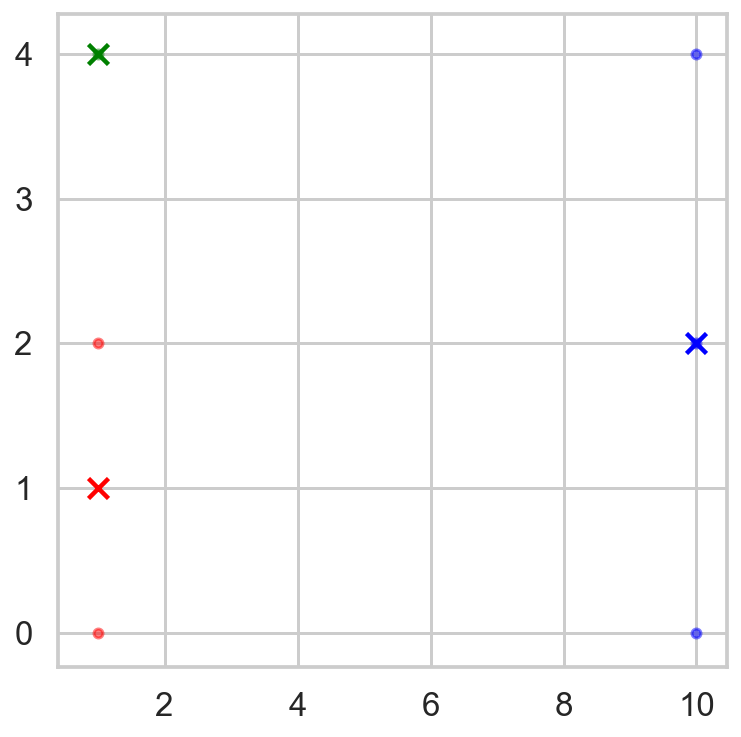

In [380]:
num_clusters = 3
km = KMeans(n_clusters=num_clusters, random_state=20, n_init=1) # n_init, number of times the K-mean algorithm will run
km.fit(X)
display_cluster(X,km,num_clusters)

In [376]:
km.labels_

array([0, 2, 0, 1, 1, 1], dtype=int32)

In [377]:
km.cluster_centers_

array([[ 1.,  1.],
       [10.,  2.],
       [ 1.,  4.]])

## Recommendation 2 - Quick & Easy Dishes
 
Goal: make recommendations for quick dishes to cook that are low in calories.
 
Quick and Easy means on average <10 ingredients

An average woman needs to eat about 2000 calories per day to maintain, 
and 1500 calories to lose one pound of weight per week. 


An average man needs 2500 calories to maintain, 
and 2000 to lose one pound of weight per week. 

That is about 44 grams to 77 grams of fat per day if you eat 2,000 calories a day. 


The American Heart Association recommends no more than 2,300 milligrams (mg) a day and moving toward an ideal limit of no more than 1,500 mg per day for most adults.

In [308]:
# filter: Recommdnations for breakfast, lunch, dinner and desserts

rec_df_break = df_rec[df_rec.categories.str.join(',').str.contains('Breakfast')==True]
rec_df_lunch = df_rec[df_rec.categories.str.join(',').str.contains('Lunch')==True]
rec_df_dinner = df_rec[df_rec.categories.str.join(',').str.contains('Dinner')==True]
rec_df_dessert = df_rec[df_rec.categories.str.join(',').str.contains('Dessert')==True]
rec_df_snack = df_rec[df_rec.categories.str.join(',').str.contains('snack')==True]

### Quick Dishes that meet the requirements:
    - Rating > 4
    - Calories < 600 per meal, total calories < 2000
    - Total fat < 44 - 77 grams per meal
    - sodium < 500 per meal. total fat < 1500 mg per day

In [62]:
# dataframe for quick dishes 
rec_df_quick = df_rec[df_rec.categories.str.join(',').str.contains('Quick')==True]
rec_df_quick.head(1)

,fat,categories,calories,protein,rating,title,ingredients,sodium,num_ingredients
4,32.0,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,20.0,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",452.0,6.0


#### DataFrames

In [63]:
# FILTER DATAFRAME TO ONLY SHOW RECIPES THAT MEET DIETARY REQUIREMENTS

# filter dataframe to only show recipes with a rating >= 4
rec_df_quick = rec_df_quick[rec_df_quick['rating'] >= 4]

# filter dataframe to only show recipes with calories per dish <= 600 
rec_df_quick = rec_df_quick[rec_df_quick['calories']  <= 600 ]

# filter dataframe to only show recipes with fat per dish <= 77 
rec_df_quick = rec_df_quick[rec_df_quick['fat']  <= 77 ]

# filter dataframe to only show recipes with sodium per dish <= 77 
rec_df_quick = rec_df_quick[rec_df_quick['sodium']  <= 500 ]

# filter dataframe to only show recipes with less than 10 ingredients
rec_df_quick = rec_df_quick[rec_df_quick['num_ingredients']  <= 10 ]

rec_df_quick.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 577 entries, 13 to 17761
Data columns (total 9 columns):
fat                577 non-null float64
categories         577 non-null object
calories           577 non-null float64
protein            577 non-null float64
rating             577 non-null float64
title              577 non-null object
ingredients        577 non-null object
sodium             577 non-null float64
num_ingredients    577 non-null float64
dtypes: float64(6), object(3)
memory usage: 45.1+ KB


In [64]:
# Quick breakfast dishes
rec_df_quick_break = rec_df_quick[rec_df_quick.categories.str.join(',').str.contains('Breakfast')==True]
rec_df_quick_break.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 49 to 15454
Data columns (total 9 columns):
fat                24 non-null float64
categories         24 non-null object
calories           24 non-null float64
protein            24 non-null float64
rating             24 non-null float64
title              24 non-null object
ingredients        24 non-null object
sodium             24 non-null float64
num_ingredients    24 non-null float64
dtypes: float64(6), object(3)
memory usage: 1.9+ KB


In [65]:
# Quick Lunch dishes
rec_df_quick_lunch = rec_df_quick[rec_df_quick.categories.str.join(',').str.contains('Lunch')==True]
rec_df_quick_lunch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 61 to 17707
Data columns (total 9 columns):
fat                42 non-null float64
categories         42 non-null object
calories           42 non-null float64
protein            42 non-null float64
rating             42 non-null float64
title              42 non-null object
ingredients        42 non-null object
sodium             42 non-null float64
num_ingredients    42 non-null float64
dtypes: float64(6), object(3)
memory usage: 3.3+ KB


In [66]:
# Quick Dinner dishes
rec_df_quick_dinner = rec_df_quick[rec_df_quick.categories.str.join(',').str.contains('Dinner')==True]
rec_df_quick_dinner.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 172 to 17386
Data columns (total 9 columns):
fat                48 non-null float64
categories         48 non-null object
calories           48 non-null float64
protein            48 non-null float64
rating             48 non-null float64
title              48 non-null object
ingredients        48 non-null object
sodium             48 non-null float64
num_ingredients    48 non-null float64
dtypes: float64(6), object(3)
memory usage: 3.8+ KB


In [67]:
# Quick Dessert dishes
rec_df_quick_dessert = rec_df_quick[rec_df_quick.categories.str.join(',').str.contains('Dessert')==True]
rec_df_quick_dessert.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 118 to 17445
Data columns (total 9 columns):
fat                85 non-null float64
categories         85 non-null object
calories           85 non-null float64
protein            85 non-null float64
rating             85 non-null float64
title              85 non-null object
ingredients        85 non-null object
sodium             85 non-null float64
num_ingredients    85 non-null float64
dtypes: float64(6), object(3)
memory usage: 6.6+ KB


### Breakfast

In [68]:
rec_df_quick_break.head()

,fat,categories,calories,protein,rating,title,ingredients,sodium,num_ingredients
49,1.0,"[Salad, Breakfast, Brunch, No-Cook, Quick & Ea...",191.0,3.0,4.375,Citrus Salad with Mint Sugar,"[2 white grapefruits, 2 pink grapefruits, 6 la...",4.0,6.0
972,3.0,"[Smoothie, Non-Alcoholic, Breakfast, Brunch, V...",234.0,5.0,4.375,"Mango, Berry & Banana Smoothie",[1 very ripe peeled banana (preferably frozen)...,111.0,9.0
2249,5.0,"[Milk/Cream, Breakfast, Brunch, Dessert, Bake,...",111.0,2.0,5.000,Mini Star-Anise Scones,"[2/3 cup (about) heavy whipping cream, divided...",117.0,7.0
2820,27.0,"[Egg, Potato, turkey, Breakfast, Brunch, Thank...",461.0,21.0,4.375,Turkey Hash,"[1 1/2 pounds medium Yukon Gold potatoes, 7 ta...",122.0,6.0
3017,17.0,"[Bread, Fruit, Breakfast, Brunch, Bake, Quick ...",304.0,4.0,4.375,Applesauce Spice Muffins,"[1 1/2 cups all-purpose flour, 1 1/2 teaspoons...",166.0,10.0


In [69]:
# create DTM
series_break_rec2 = rec_df_quick_break['ingredients'].astype(str)

# tfidf vectorizor for recommendation 2
tfidf_rec2 = TfidfVectorizer(stop_words='english', max_df = .9, min_df=.1, ngram_range=(1,2))

# Fit and transform on DTM
doc_word_tfidf_rec2 = tfidf_rec2.fit_transform(series_break_rec2)

# Put DTM in chart
dtm_rec2 = pd.DataFrame(doc_word_tfidf_rec2.toarray(), index=series_break_rec2, columns=tfidf_rec2.get_feature_names())

# Calculate the pairwise cosine similarities 
CS_rec2 = cosine_similarity(dtm_rec2)
CS_rec2

array([[1.        , 0.        , 0.04947902, 0.03639535, 0.04459273,
        0.17892404, 0.02007067, 0.32570257, 0.11640572, 0.15781288,
        0.10155151, 0.1085231 , 0.23651728, 0.18027557, 0.        ,
        0.38071142, 0.30786559, 0.21609472, 0.03126707, 0.45275501,
        0.03868255, 0.10116627, 0.07484192, 0.06750689],
       [0.        , 1.        , 0.0732918 , 0.        , 0.06605388,
        0.0710467 , 0.        , 0.12423575, 0.        , 0.3219424 ,
        0.07997466, 0.12819748, 0.08725113, 0.19083777, 0.07645786,
        0.        , 0.27093368, 0.40163722, 0.09824995, 0.08707584,
        0.18256538, 0.        , 0.04943427, 0.        ],
       [0.04947902, 0.0732918 , 1.        , 0.19109917, 0.39831846,
        0.35612123, 0.49680831, 0.13775492, 0.20242666, 0.08647803,
        0.45811835, 0.2478757 , 0.18633689, 0.31808995, 0.21427853,
        0.0730696 , 0.13516024, 0.0226065 , 0.61669559, 0.07331863,
        0.33035821, 0.47489041, 0.33139147, 0.13645407],
       [0.036

In [156]:
# create a function that returns the index of the top recommendations in the matrix

def make_rec(index, matrix):
        
        sim = matrix[index]
        
        # create a mask to exclude the value of 1 (which is the item istself)
        ma = np.ma.masked_where(sim > 0.9, sim, copy = False)
        
        
        ma_max = ma.max()
        ma_index = ma.argmax()
        
        return  ma_max, ma_index

In [161]:
# Smoothie receipe
CS_rec2[3]

array([0.03639535, 0.        , 0.19109917, 1.        , 0.173934  ,
       0.10510849, 0.09980672, 0.44019104, 0.06117018, 0.3930244 ,
       0.09187618, 0.19251505, 0.09598066, 0.164218  , 0.01184345,
       0.1959523 , 0.03296496, 0.06839215, 0.19868509, 0.07442642,
       0.12573664, 0.07106396, 0.16887415, 0.2969626 ])

In [179]:
# make recommendations based on Berry Smoothie recipe #1
make_rec(1,CS_rec2)

(0.4016372241386203, 22)

In [181]:
# return the recipe
rec_df_quick_break['title'].iloc[22]

'Whole Wheat Pancakes with Bananas and Pecans '

In [182]:
rec_df_quick_break.iloc[22]

fat                                                                6
categories         [Dairy, Egg, Fruit, Nut, Breakfast, Brunch, Ve...
calories                                                         141
protein                                                            4
rating                                                         4.375
title                  Whole Wheat Pancakes with Bananas and Pecans 
ingredients        [1 1/4 cups whole wheat flour, 3/4 cup unbleac...
sodium                                                           201
num_ingredients                                                   10
Name: 14951, dtype: object

### Lunch

In [192]:
rec_df_quick_lunch[rec_df_quick_lunch.categories.str.join(',').str.contains('Sandwich')==True]
rec_df_quick_lunch

,fat,categories,calories,protein,rating,title,ingredients,sodium,num_ingredients
61,32.0,"[Salad, Side, Fourth of July, Quick & Easy, Ba...",368.0,6.0,4.375,"Romaine, Grilled Avocado, and Smoky Corn Salad...","[1/4 cup grated parmesan, 1/2 cup extra-virgin...",112.0,9.0
264,3.0,"[Pasta, Side, Quick & Easy, Lunch, Lemon, Lime...",200.0,8.0,4.375,Cold Noodle Salad with Ponzu Sauce,"[3/4 cup Sanuki Sea Stock, 3 tablespoons soy s...",486.0,5.0
268,3.0,"[Soup/Stew, Pasta, Quick & Easy, Lunch, Boil, ...",272.0,10.0,4.375,To Cook Dried Udon Noodles,[10 ounces dried or semidried (slightly flexib...,15.0,9.0
545,16.0,"[Salad, Vegetable, Side, No-Cook, Vegetarian, ...",202.0,7.0,4.375,Beet Carpaccio with Goat Cheese and Arugula,"[3 medium beets, peeled and stems trimmed to 2...",187.0,3.0
730,29.0,"[Soup/Stew, Milk/Cream, Blender, Thanksgiving,...",335.0,13.0,4.375,Creamy Fennel and Greens Soup,"[1 tablespoon olive oil, 1 tablespoon unsalted...",111.0,6.0
980,13.0,"[Soup/Stew, Milk/Cream, Blender, Dairy, Herb, ...",362.0,14.0,4.375,Yukon Gold Potato and Chive Soup,[7 cups (or more) canned low-salt chicken brot...,323.0,5.0
1229,9.0,"[Soup/Stew, Ginger, Tomato, Quick & Easy, Lunc...",126.0,4.0,4.375,Moroccan-Spiced Cold Tomato Soup,"[1 small onion, chopped, 2 tablespoons olive o...",142.0,8.0
2602,35.0,"[Salad, Milk/Cream, Chicken, Pasta, Tomato, Qu...",588.0,55.0,4.375,Chicken Pasta Salad in Creamy Curry Dressing,"[1/4 pound rotelle, 1 whole skinless boneless ...",179.0,4.0
2756,13.0,"[Sandwich, Chicken, Poach, Quick & Easy, Lunch...",220.0,10.0,4.375,Chicken Salad Tea Sandwiches with Smoked Almonds,"[3 cups chicken broth or water, 2 whole bonele...",277.0,6.0
3129,29.0,"[Salad, Chicken, Leafy Green, Nut, Poultry, Pi...",304.0,4.0,4.375,Cold-Smoked Chicken with Baby Bok Choy and Cas...,"[6 baby bok choy, separated into leaves, 2 tab...",292.0,4.0


In [184]:
# Create DTM

series_lunch_rec2 = rec_df_quick_lunch['ingredients'].astype(str)

# tfidf vectorizor for recommendation 2
tfidf_rec2_lunch = TfidfVectorizer(stop_words='english', max_df = .9, min_df=.1, ngram_range=(1,2))

# Fit and transform on data
doc_word_tfidf_rec2_lunch = tfidf_rec2_lunch.fit_transform(series_lunch_rec2)

# DTM
dtm_rec2_lunch = pd.DataFrame(doc_word_tfidf_rec2_lunch.toarray(), index=series_lunch_rec2, columns=tfidf_rec2_lunch.get_feature_names())

# Calculate the pairwise cosine similarities 
CS_rec2_lunch = cosine_similarity(dtm_rec2_lunch)
CS_rec2_lunch

array([[1.        , 0.21988084, 0.07352599, ..., 0.20190364, 0.25046265,
        0.23646584],
       [0.21988084, 1.        , 0.47047063, ..., 0.25114144, 0.15004205,
        0.06405482],
       [0.07352599, 0.47047063, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.20190364, 0.25114144, 0.        , ..., 1.        , 0.0960325 ,
        0.04188819],
       [0.25046265, 0.15004205, 0.        , ..., 0.0960325 , 1.        ,
        0.41558027],
       [0.23646584, 0.06405482, 0.        , ..., 0.04188819, 0.41558027,
        1.        ]])

In [200]:
# Make a recommendation based on Turkey Torta (#10)
make_rec(11,CS_rec2_lunch)

(0.48650078601833746, 12)

In [201]:
# the recipe name
rec_df_quick_lunch['title'].iloc[12]

'Ham and Swiss Puff-Pastry Quiche '

### Dinner

In [197]:
# Create DTM

series_dinner_rec2 = rec_df_quick_dinner['ingredients'].astype(str)

# tfidf vectorizor for recommendation 2
tfidf_rec2_dinner = TfidfVectorizer(stop_words='english', max_df = .9, min_df=.1, ngram_range=(1,2))

# Fit and transform on data
doc_word_tfidf_rec2_dinner = tfidf_rec2_dinner.fit_transform(series_dinner_rec2)

# DTM
dtm_rec2_dinner = pd.DataFrame(doc_word_tfidf_rec2_dinner.toarray(), index=series_dinner_rec2, columns=tfidf_rec2_dinner.get_feature_names())

# Calculate the pairwise cosine similarities 
CS_rec2_dinner = cosine_similarity(dtm_rec2_dinner)
CS_rec2_dinner

array([[1.        , 0.42258443, 0.46468865, ..., 0.09128988, 0.2014137 ,
        0.27395709],
       [0.42258443, 1.        , 0.24247231, ..., 0.22892751, 0.13441979,
        0.20440524],
       [0.46468865, 0.24247231, 1.        , ..., 0.28977034, 0.22778702,
        0.16203893],
       ...,
       [0.09128988, 0.22892751, 0.28977034, ..., 1.        , 0.48160942,
        0.29884898],
       [0.2014137 , 0.13441979, 0.22778702, ..., 0.48160942, 1.        ,
        0.34878107],
       [0.27395709, 0.20440524, 0.16203893, ..., 0.29884898, 0.34878107,
        1.        ]])

In [ ]:
## LEFT OFF

In [206]:
# Make a recommendation based on Salmon with Sriracha Sauce and Lime
make_rec(47,CS_rec2_dinner)

(0.46377395827647494, 32)

In [207]:
# the recipe name
rec_df_quick_dinner['title'].iloc[32]

'Peppered Pork Tenderloin with Cherry Salsa '

### Dessert

In [217]:
rec_df_quick_dessert.head(25)


,fat,categories,calories,protein,rating,title,ingredients,sodium,num_ingredients
118,0.0,"[Sauce, Blender, Dessert, Quick & Easy, Low So...",129.0,1.0,4.375,Blackberry-Raspberry Sauce,"[1/2 cup sugar, 1/3 cup water, 1 cup picked-ov...",2.0,5.0
190,30.0,"[Chocolate, Fruit, Nut, Dessert, Bake, Quick &...",437.0,5.0,4.375,Chocolate Pecan Banana Tarts,[1/2 sheet frozen puff pastry (about 1/4 pound...,74.0,6.0
392,28.0,"[Sauce, Milk/Cream, Dessert, Quick & Easy, Kid...",395.0,1.0,5.000,Toffee Sauce,"[2 tablespoons unsalted butter, 1/2 cup lightl...",88.0,9.0
500,0.0,"[Ginger, Brunch, Dessert, Quick & Easy, Peach,...",102.0,0.0,4.375,Peaches in Ginger Syrup,"[3/4 cup dry white wine, 3/4 cup water, 3/4 cu...",2.0,8.0
856,21.0,"[Mixer, Dairy, Dessert, No-Cook, Quick & Easy,...",290.0,2.0,4.375,Maple-Cream Cheese Icing,"[2 8-ounce packages cream cheese, room tempera...",141.0,6.0
892,7.0,"[Mixer, Egg, Dessert, Quick & Easy, Grapefruit...",216.0,4.0,5.000,Lemon Sabayon with Grapefruit,"[3 grapefruits, 2 whole large eggs, 2 large eg...",27.0,7.0
944,18.0,"[Cookies, Mixer, Nut, Vegetable, Dessert, Bake...",297.0,4.0,4.375,Inside-Out Carrot Cake Cookies,"[1 1/8 cups all-purpose flour, 1 teaspoon cinn...",216.0,8.0
1094,15.0,"[Milk/Cream, Tea, Ice Cream Machine, Dairy, Eg...",297.0,3.0,4.375,Earl Grey Ice Cream,"[6 cups milk, 1 vanilla bean, 8 Earl Grey tea ...",48.0,6.0
1174,10.0,"[Sauce, Fruit Juice, Chocolate, Dessert, Passo...",146.0,1.0,4.375,Sweet Chocolate Glaze,"[3 ounces semisweet or bittersweet chocolate, ...",47.0,7.0
1184,14.0,"[Berry, Dairy, Dessert, Quick & Easy, Cream Ch...",218.0,3.0,4.375,Berries with Geranium Cream,"[1 cup heavy cream, 2 tablespoons finely chopp...",78.0,8.0


In [220]:
# Create DTM

series_dessert_rec2 = rec_df_quick_dessert['ingredients'].astype(str)

# tfidf vectorizor for recommendation 2
tfidf_rec2_dessert = TfidfVectorizer(stop_words='english', max_df = .9, min_df=.1, ngram_range=(1,2))

# Fit and transform on data
doc_word_tfidf_rec2_dessert = tfidf_rec2_dessert.fit_transform(series_dessert_rec2)

# DTM
dtm_rec2_dessert = pd.DataFrame(doc_word_tfidf_rec2_dessert.toarray(), index=series_dessert_rec2, columns=tfidf_rec2_dessert.get_feature_names())

# Calculate the pairwise cosine similarities 
CS_rec2_dessert = cosine_similarity(dtm_rec2_dessert)
CS_rec2_dessert

array([[1.        , 0.11989348, 0.07267072, ..., 0.11893944, 0.58162835,
        0.0140841 ],
       [0.11989348, 1.        , 0.17565892, ..., 0.05612041, 0.23630262,
        0.04447701],
       [0.07267072, 0.17565892, 1.        , ..., 0.23961315, 0.0602735 ,
        0.1388191 ],
       ...,
       [0.11893944, 0.05612041, 0.23961315, ..., 1.        , 0.11824248,
        0.09323953],
       [0.58162835, 0.23630262, 0.0602735 , ..., 0.11824248, 1.        ,
        0.0460547 ],
       [0.0140841 , 0.04447701, 0.1388191 , ..., 0.09323953, 0.0460547 ,
        1.        ]])

In [228]:
# Make a recommendation based on Earl Grey Ice Cream
make_rec(7,CS_rec2_dessert)

(0.7197475321163238, 65)

In [229]:
# the recipe name
rec_df_quick_dessert['title'].iloc[65]

'Chai-Poached Apricots and Plums '

In [400]:
#rec_df_quick_dessert = 
rec_df_quick[rec_df_quick.categories.str.join(',').str.contains('Thanksgiving')==True]


,fat,categories,calories,protein,rating,title,ingredients,sodium,num_ingredients
57,10.0,"[Breakfast, Brunch, Bake, Thanksgiving, Kid-Fr...",223.0,4.0,4.375,Pumpkin Muffins,"[1/3 cup golden raisins, 2 cups all-purpose fl...",211.0,17.0
358,14.0,"[Onion, Vegetable, Side, Sauté, Thanksgiving, ...",313.0,7.0,3.125,Broccoli Rabe and Butternut Squash,[1/2 small butternut squash (about 1 1/2 pound...,45.0,12.0
462,0.0,"[Condiment/Spread, Sauce, Thanksgiving, Quick ...",253.0,1.0,3.750,Cranberry Kumquat Compote,"[1/4 pound kumquats (about 10), a 12-ounce bag...",7.0,4.0
469,NaN,"[Side, Thanksgiving, Low Fat, Quick & Easy, Lo...",NaN,NaN,4.375,Cranberry-Pepper Jelly,"[3 red bell peppers, finely chopped, 2 Fresno ...",NaN,10.0
600,3.0,"[Condiment/Spread, Berry, Side, Christmas, Tha...",153.0,1.0,4.375,Cranberry Black Pepper Chutney,"[1/3 cup finely chopped shallot, 1 tablespoon ...",149.0,7.0
...,...,...,...,...,...,...,...,...,...
19398,NaN,"[Ginger, Side, Christmas, Thanksgiving, Low Fa...",NaN,NaN,3.750,Maple-Ginger Butternut Squash,"[2 1/2 lb butternut squash (1 large), 2 teaspo...",NaN,NaN
19711,73.0,"[Side, Fry, Thanksgiving, Vegetarian, Quick & ...",777.0,4.0,2.500,Crispy Shallots,"[2 cups canola oil, 1 cup all-purpose flour, K...",17.0,NaN
19818,60.0,"[Game, Poultry, Roast, Christmas, Picnic, Than...",866.0,74.0,3.750,Grandma's Roasted Cornish Game Hens,"[2 (1 1/2-lb) Cornish game hens, halved length...",844.0,NaN
19870,19.0,"[Bon Appétit, Herb, Barley, Vegetarian, Thanks...",265.0,6.0,4.375,Herby Barley Salad With Butter-Basted Mushrooms,"[1 cup hulled, hull-less, or pearl barley, Kos...",85.0,NaN
